# Getting some style: fantasy maps

Our objective today: make a stylized map of Middle Earth that's similar to those in the front pages of the books.
I saw [this map of Middle Earth](https://www.r-bloggers.com/interactive-and-styled-middle-earth-map/) made with R. Being a Pythonist, felt that the gauntlet had been thrown down.

It's pretty easy to map geography with Geopandas or Matplotlib, but styling it to look the way you want can take you deep into the weeds of documentation. But that's where we're going today. Let's check out what we've got using Geopandas.

In [1]:
import pandas
import geopandas
import numpy as np
import fiona
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

I'm keeping the repository in a separate folder dedicated to datasets, but you can clone the repository at https://github.com/jvangeld/ME-GIS.

In [2]:
path = '../../datamancery/geo/ME-GIS-master/'
coasts =  geopandas.read_file(path + 'Coastline2.shp')
contours =geopandas.read_file(path + 'Contours_18.shp')
contours2=geopandas.read_file(path + 'HelperContours.shp')
cities =  geopandas.read_file(path + 'Cities.shp')
forests = geopandas.read_file(path + 'Forests.shp')
towns =   geopandas.read_file(path + 'Towns.shp')
lakes =   geopandas.read_file(path + 'Lakes2.shp')
rivers =  geopandas.read_file(path + 'Rivers19.shp')
roads =   geopandas.read_file(path + 'PrimaryRoads.shp')

In [3]:
cities.sample(5)

GM_LAYER GM_TYPE LAYER            Name  \
14     City    City  City  Caras Galadhon   
24     City    City  City          Erebor   
21     City    City  City    Minas Morgul   
0      City    City  City            None   
23     City    City  City       Barad-Dur   

                                       geometry  
14  POINT (969295.6418884165 921785.9769954863)  
24  POINT (1257090.321389413 1179668.006097761)  
21   POINT (1169735.49716198 637426.5822034229)  
0   POINT (240259.0304054883 1071846.337394591)  
23  POINT (1253667.518910979 670547.8071835057)

In [4]:
contours.sample()

NAME           GM_LAYER            GM_TYPE              LAYER   ID  \
1578  None  Unknown Line Type  Unknown Line Type  Unknown Line Type  334   

        Elevation  Colour      LENGTH BEARING PERIMETER ENCLOSED_A  \
1578  5524.500000     0.0  2.95 miles   13.6°      None       None   

      1_8288_met ISLAND_ARE                                           geometry  
1578         NaN       None  LINESTRING (850720.6076481116 528748.893006286...

Now, the contours is interesting. These are the topographic contours of mountains and valleys, which should give our map a nice texture. It actually includes underwater topography (i.e. bathymetry), but weirdly the elevation for everything is still positive. 

First we need to fill in missing elevation, and convert everything to a number.

In [5]:
contours['Elevation'] = contours['Elevation'].fillna('0')
contours['Elevation'] = contours['Elevation'].map(lambda elv: float(elv.replace('m', '')))

Now in order to find the water level (and thus the coastline), we should be able to just find the most common elevation.

In [6]:
contours.Elevation.value_counts().head()

5486.40    446
5480.00    220
5505.45    198
5500.00    174
5460.00    122
Name: Elevation, dtype: int64

Let's plot that against the coastline DataFrame we have to make sure.

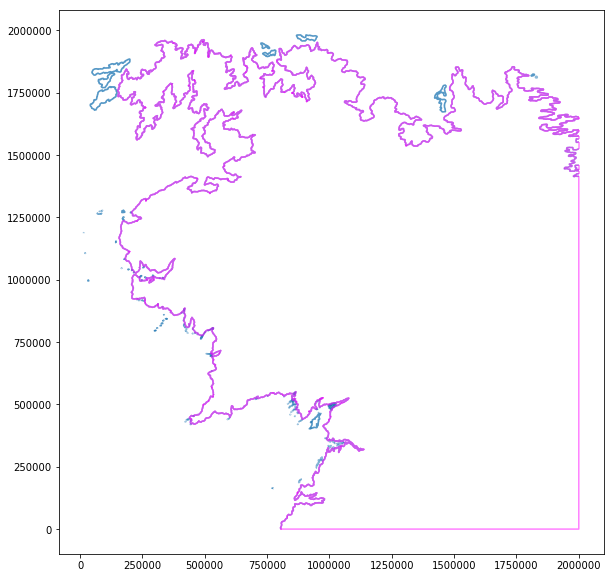

In [7]:
base = contours[contours.Elevation == 5486.4].plot(figsize=(10,10), alpha=0.5)
coasts.plot(ax=base, alpha=0.5, color="magenta")

Yup, so the coastline is at 5486.4 meters. Let's bring that to zero so everything underwater is negative.

In [8]:
contours.Elevation -= 5486.4
print(contours.Elevation.min())
print(contours.Elevation.max())

-5486.4
4876.8


Cool, now we're ready to look at the simplest possible map of all these elements, just using some alpha values to keep a few of the geographic features from overwhelming the map.

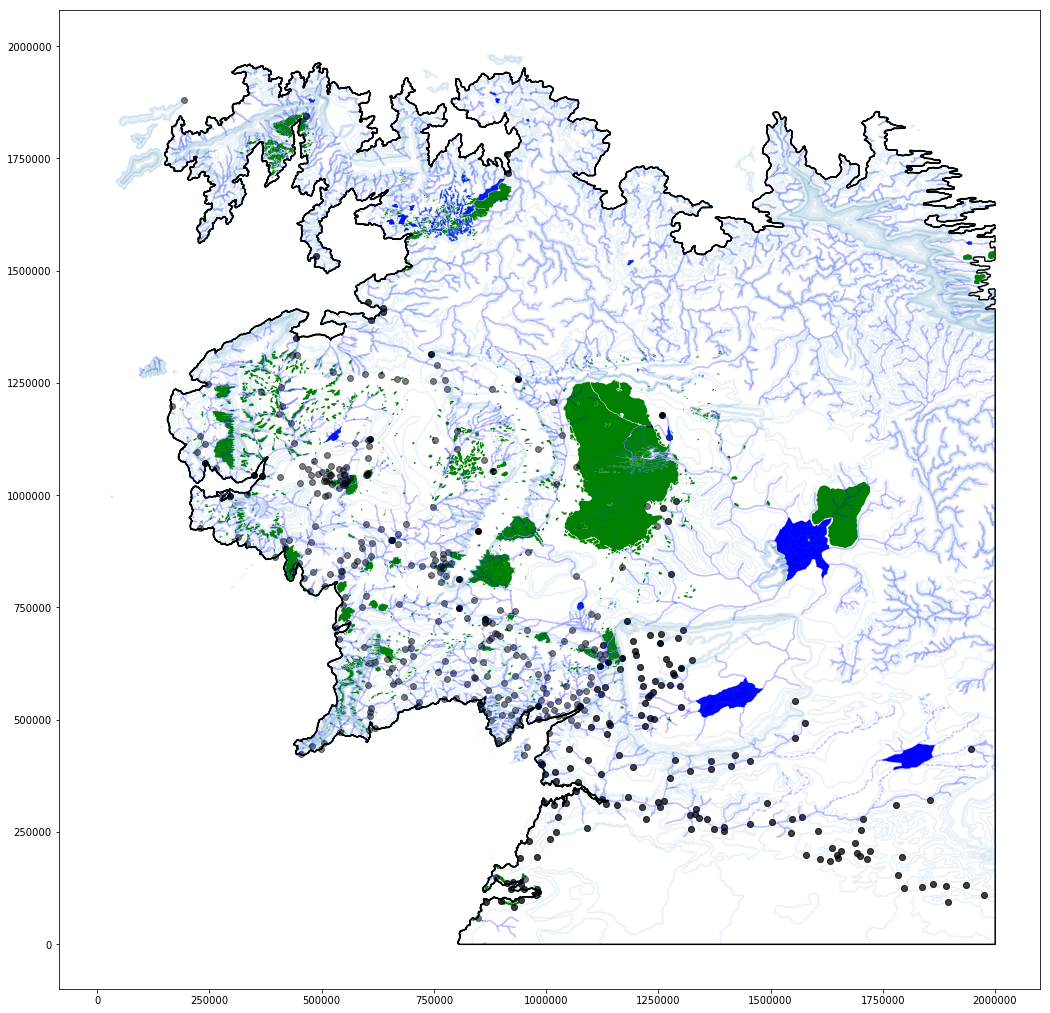

In [9]:
base = coasts.plot(color="black", figsize=(18,18))
cities.plot(ax=base, color="black")
forests.plot(ax=base, color="green")
towns.plot(ax=base, color="black", alpha=0.5)
lakes.plot(ax=base, color="blue")
contours[contours.Elevation > 0].plot(ax=base, alpha=0.1)
rivers.plot(ax=base, color="blue", alpha=0.25)
base

First thing we can do is just make the colors nicer. We'll be going for an old-paper kind of feel, so off-white and muted colors are a must. We'll also trim some of the map so it's more focused, and get rid of those distracting islands that don't have coastline. I'm going to write this as a function that returns a matplotlib Axes object that we can add further text and stuling to.

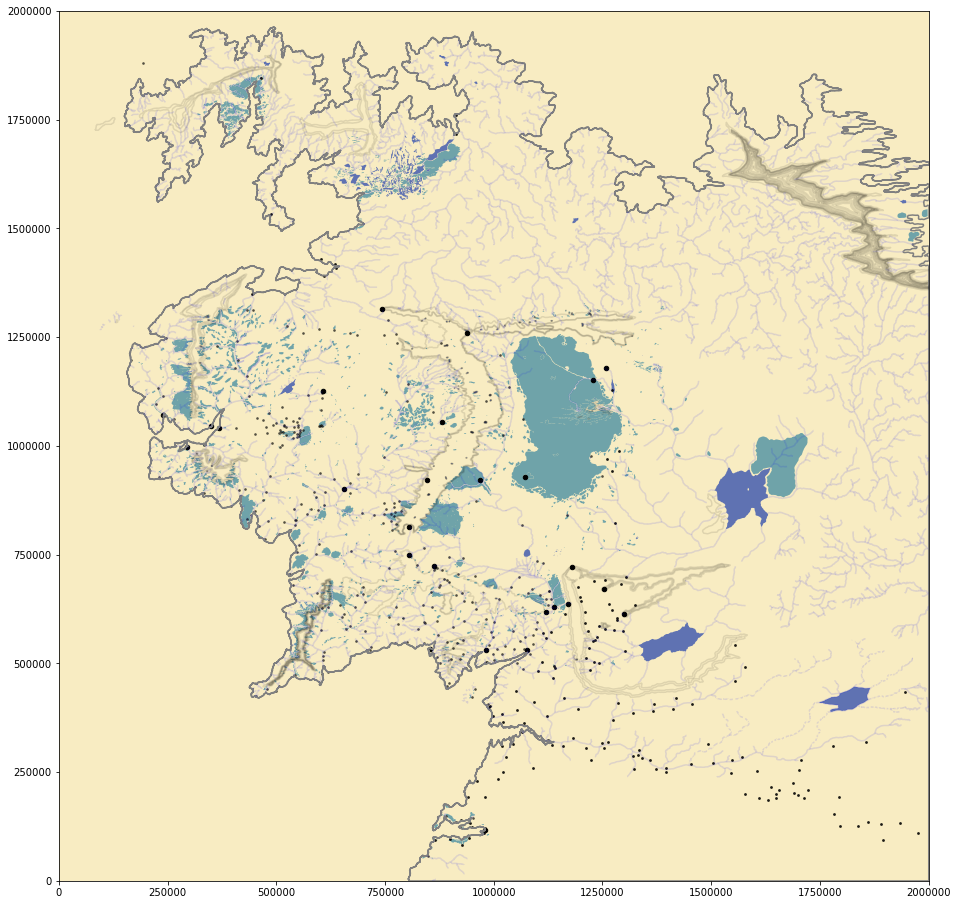

In [10]:
def plot_base():
    base = coasts.plot(color="grey", figsize=(16,16))
    base.patch.set_facecolor('#F8ECC2')
    forests.plot(ax=base, color="#6fa3a9")
    lakes.plot(ax=base, color="#5f72b2")
    contours[contours.Elevation > 1000].plot(ax=base, color="black", alpha=0.1)
    rivers.plot(ax=base, color="blue", alpha=0.1)
    cities.plot(ax=base, color="black", markersize=20)
    towns.plot(ax=base, color="black", alpha=0.5, markersize=3)
    return base

base = plot_base()
plt.xlim([25, 2000000])
plt.ylim([25, 2000000])
base

Next we can try drawing the labels just of the cities, and see how it looks. I'm also going to add in the map title, and remove the pointless x and y axes.

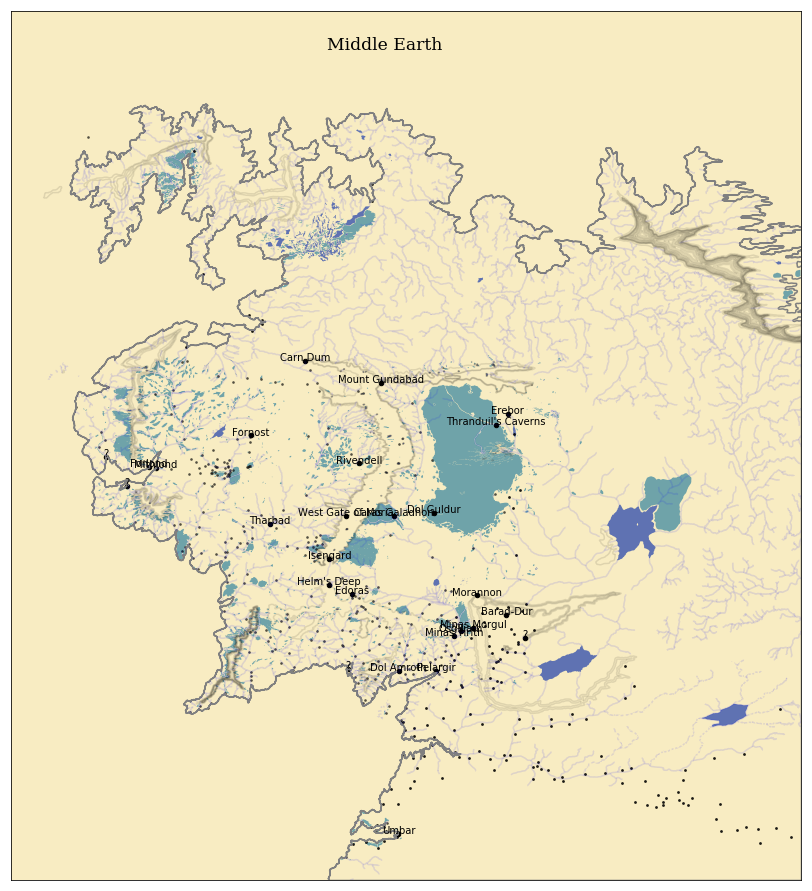

In [11]:
base = plot_base()

plt.xlim([50, 2000000])
plt.ylim([50, 2200000])
for idx, row in cities.iterrows():
    name = row.Name if row.Name else '?'
    text_coords = [arr.tolist()[0] for arr in row.geometry.xy]
    plt.annotate(s=name, xy=text_coords, horizontalalignment='center', size="medium")
base.xaxis.set_visible(False)
base.yaxis.set_visible(False)
base.text(800000, 2100000, "Middle Earth", size="xx-large", family="serif")
base

That's some serious overlapping. We'll handle that soon. But first, if we really want to get the map looking nice, we'll have to dive into the world of fonts.

### Finding the available fonts

Any well-styled map should choose its fonts carefully, and it would be nice to have a more hand-drawn look than the serif matplotlib font will give us. But matplotlib doesn't necessarily have all the fonts that our system has, so it would be nice to get a look at what's immediately available to us without having to install new fonts. We can do this by listing all the fonts using matplotlib's Font Manager, and then make a chart with text using each of those fonts in turn.

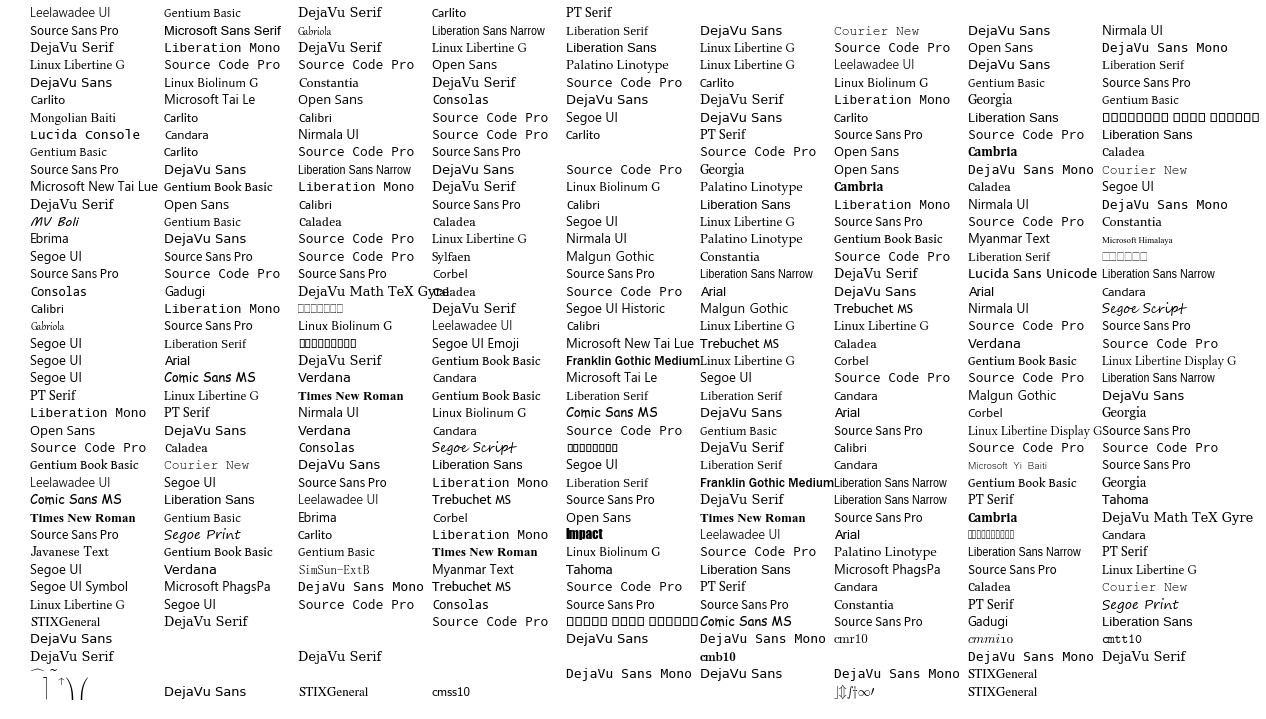

In [12]:
font_manager = matplotlib.font_manager.FontManager()
available_fonts = [font.name for font in font_manager.ttflist]
fig = plt.figure()
ax = fig.add_subplot(111) # two rows, one column, first plot
ax.axis('off')

xi = 0
yi = 0
y_inc = 0.08
x_inc = y_inc * 5
for name in available_fonts:
    ax.text(xi, yi, name, family=name, size=13)
    xi += x_inc
    if xi > x_inc * 8:
        xi = 0
        yi += y_inc
    if yi > y_inc * 50:
        print("overflowing for {}".format(name))
        break
base

Gabriola, in the middle of the right-most column, is a nice cursive font. Let's use that.

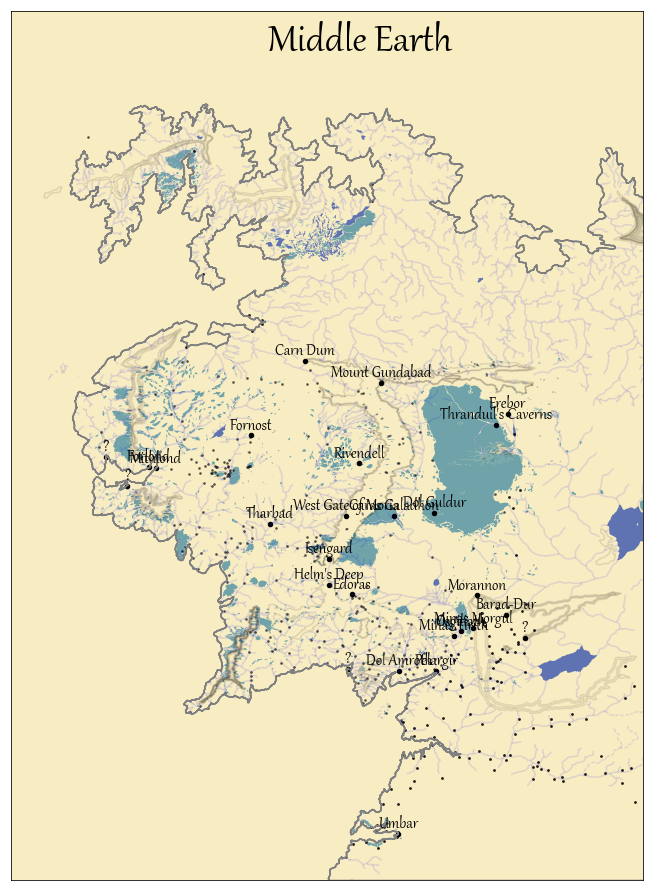

In [13]:
base = plot_base()

plt.xlim([50, 1600000])
plt.ylim([50, 2200000])
for idx, row in cities.iterrows():
    name = row.Name if row.Name else '?'
    text_coords = [arr.tolist()[0] for arr in row.geometry.xy]
    text_coords[1] += 15000
    plt.annotate(s=name, xy=text_coords, horizontalalignment='center', size=18, family="Gabriola")
base.xaxis.set_visible(False)
base.yaxis.set_visible(False)
base.text(650000, 2100000, "Middle Earth", size=45, family="Gabriola")
base

### Stochastic, single-axis automatic label layout

We still need to deal with those annoying overlapping labels. Admittedly, there are only 27 different city names, so we could just manually position them. But let's try for a more generalizable solution. We could do a kind of [force-directed layout](https://en.wikipedia.org/wiki/Force-directed_graph_drawing), which gives each node (city label) the property of repulsing other nodes while also being anchored to the actual city location. It's an excellent solution, but we can get away with something even simpler here.

We can eliminate most of the overlapping by taking a few of the labels and moving them slightly up or down. So if we only paid attention to the y-axis and tried to get it so that labels weren't within a certain distance of each other in only that dimension, then we could get a lot of the way there and it might look good enough for our purposes.

So in the following code, we'll define a new column that keeps track of the y coordinates of the text label. If does a diff on that Series, which will detect when a given label has a y value close to the previous entry. Then we iterate over each of those too-close labels and randomly move it up or down some amount (and reset it if it moves too far). We keep iterating over that until we reach a certain value that, in testing, is pretty much as good as we'll get. But have a look below--this actually comes out surprisingly well, and all the labels are at least legible.

In [14]:
cities['text_y'] = cities.geometry.map(lambda point: point.y + 1500)
cities[["Name", "text_y"]].sort_values(by="text_y")
labels_close = cities.text_y.diff() < 25000
iterations = 0
while labels_close.sum() > 10:
#     print(labels_close.sum(), end=" ")
    iterations += 1
    for i in range(len(cities)):
        if labels_close[i]:
            mult = np.random.random() - 0.5
            if abs(cities.loc[i, ("text_y")] - cities.loc[i].geometry.y) < 200000:
                cities.loc[i, ("text_y")] += 20000 * mult
            else:
                cities.loc[i, ("text_y")] = (cities.loc[i].geometry.y + cities.loc[i, ("text_y")]) / 2
                
    labels_close = cities.text_y.diff() < 25000
# pandas.Series(iterations).plot()
print("iterations:", iterations)

iterations: 46


This was an interesting way of doing automatic text layout, but probably isn't the kind of solution you want to do with massive datasets.

Now we'll go through all that plotting again, using the new y coordinates for the text that we just generated. I'm going to roll this up into a function that puts a few regional labels onto the map. 

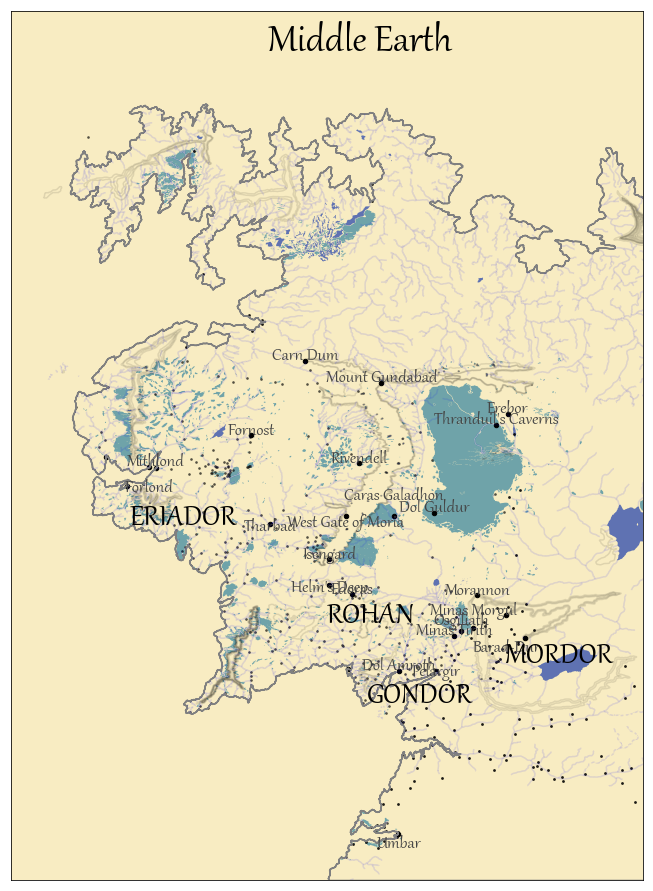

In [15]:
base = plot_base()

def draw_labels(base):
    for idx, row in cities.iterrows():
        name = row.Name if row.Name else ''
        text_coords = [row.geometry.x, row.text_y]
        plt.annotate(s=name, xy=text_coords, horizontalalignment='center', size=20, family="Gabriola", color="#444444")
    base.text(300000, 900000, "ERIADOR", size=34, family="Gabriola")
    base.text(800000, 650000, "ROHAN", size=34, family="Gabriola")
    base.text(900000, 450000, "GONDOR", size=34, family="Gabriola")
    base.text(1250000, 550000, "MORDOR", size=34, family="Gabriola")
    base.text(650000, 2100000, "Middle Earth", size=45, family="Gabriola")

draw_labels(base)

plt.xlim([50, 1600000])
plt.ylim([50, 2200000])

base.xaxis.set_visible(False)
base.yaxis.set_visible(False)
base

Not bad. Let's put in some finishing text, a Tolkien quote, and call it good.

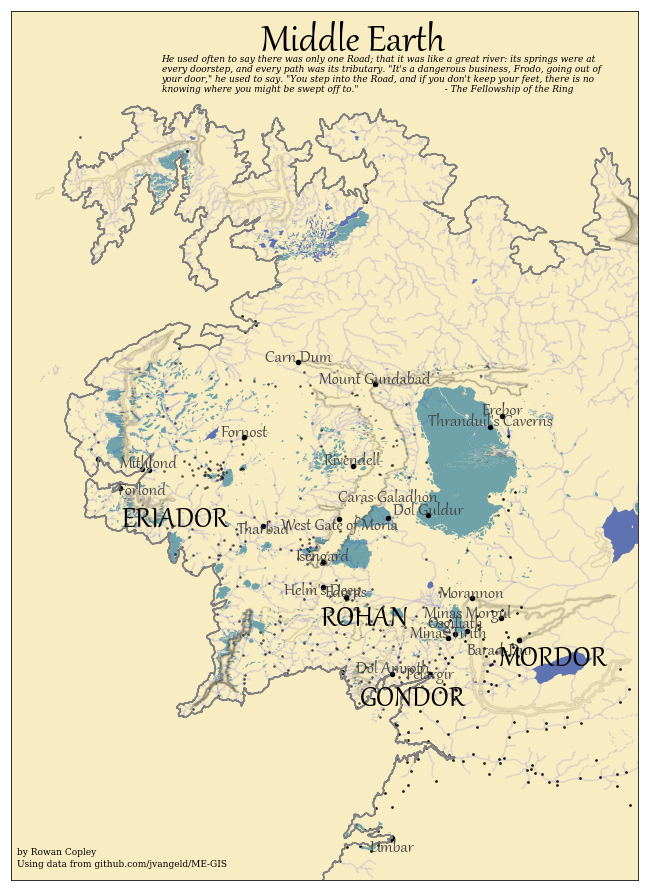

In [16]:
base = plot_base()

draw_labels(base)

plt.xlim([20000, 1600000])
plt.ylim([10000, 2200000])

base.xaxis.set_visible(False)
base.yaxis.set_visible(False)

base.text(35000, 75000, "by Rowan Copley", size=9, family="serif")
base.text(35000, 45000, "Using data from github.com/jvangeld/ME-GIS", size=9, family="serif")
start_quote = 2070000
quote_spacing = 25000
quote = (
    'He used often to say there was only one Road; that it was like a great river: its springs were at ',
    'every doorstep, and every path was its tributary. "It\'s a dangerous business, Frodo, going out of',
    'your door," he used to say. "You step into the Road, and if you don\'t keep your feet, there is no ',
    'knowing where you might be swept off to."                              - The Fellowship of the Ring'
)
for i in range(len(quote)):
    base.text(400000, start_quote - quote_spacing * i, quote[i], family="serif", style="italic", size=9)

plt.savefig('images/middle_earth.png', bbox_inches="tight")

Our map is done, and suitably stylish as to be used on an adventure by any denizen of Middle Earth. It could be manually cleaned up to take it up a notch or two, but that's not what this notebook is about. While the road does indeed go ever on and on, this notebook is finished.

### References

Original inspiration: [Map of Middle Earth in R](https://www.r-bloggers.com/interactive-and-styled-middle-earth-map/)

Geo files: [Middle Earth GIS](https://github.com/jvangeld/ME-GIS)

Reference material: [Matplotlib Text](http://matplotlib.org/api/text_api.html#matplotlib.text.Text)